# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

Выполнил Субботин Артём м8О-311б-22

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

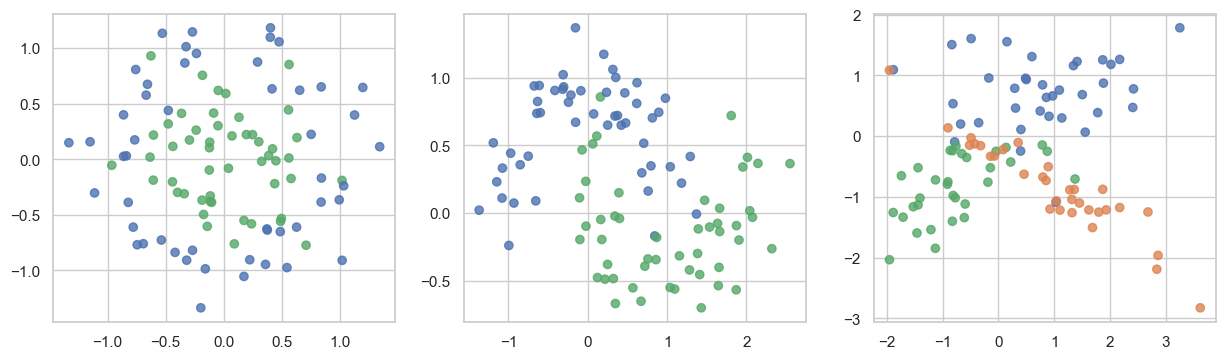

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [7]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

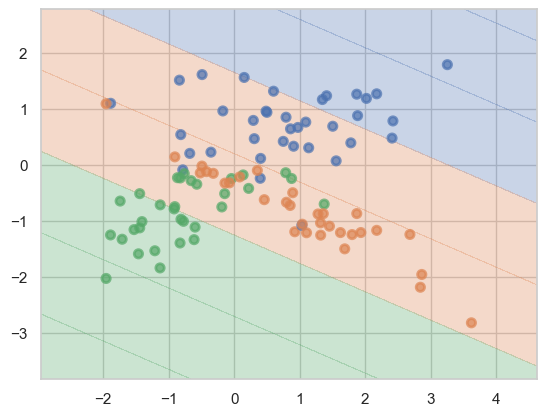

In [8]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1 — Accuracy train: 1.00, test: 0.77
Dataset 2 — Accuracy train: 1.00, test: 0.93
Dataset 3 — Accuracy train: 1.00, test: 0.80


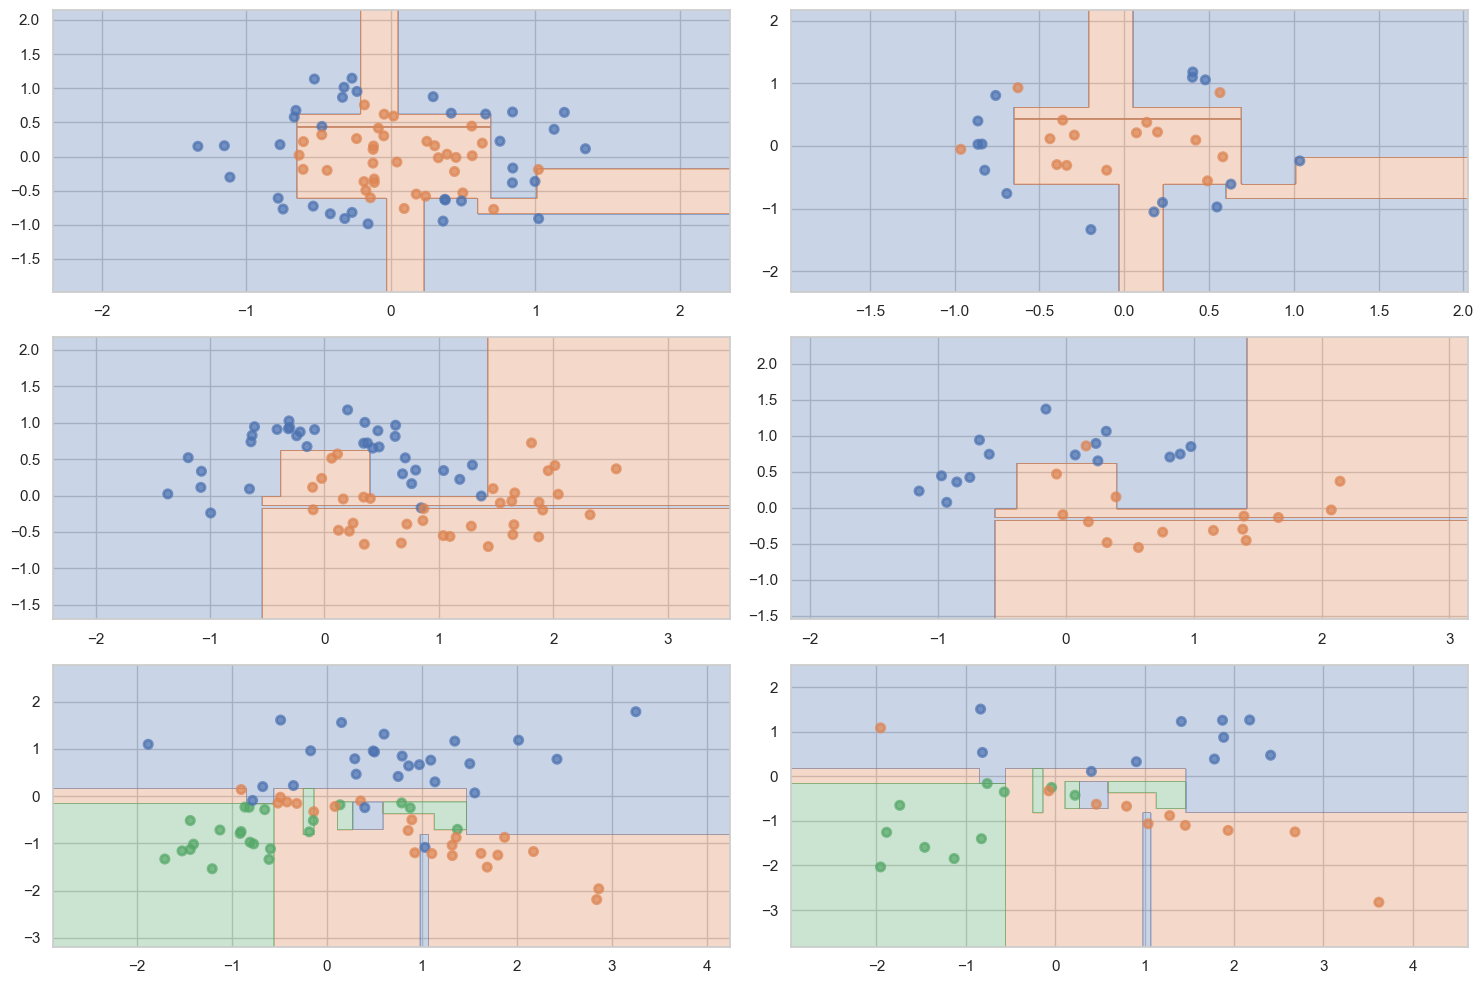

In [29]:
plt.figure(figsize=(15, 10))

for i, (X, y) in enumerate(datasets):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)

    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)
    print(f"Dataset {i+1} — Accuracy train: {acc_train:.2f}, test: {acc_test:.2f}")

    plt.subplot(3, 2, 2 * i + 1)
    plot_surface(clf, X_train, y_train)

    plt.subplot(3, 2, 2 * i + 2)
    plot_surface(clf, X_test, y_test)
    
plt.tight_layout()
plt.show()

__Ответ:__ Решающие деревья с параметрами по умолчанию демонстрируют сильное переобучение на всех трех датасетах

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

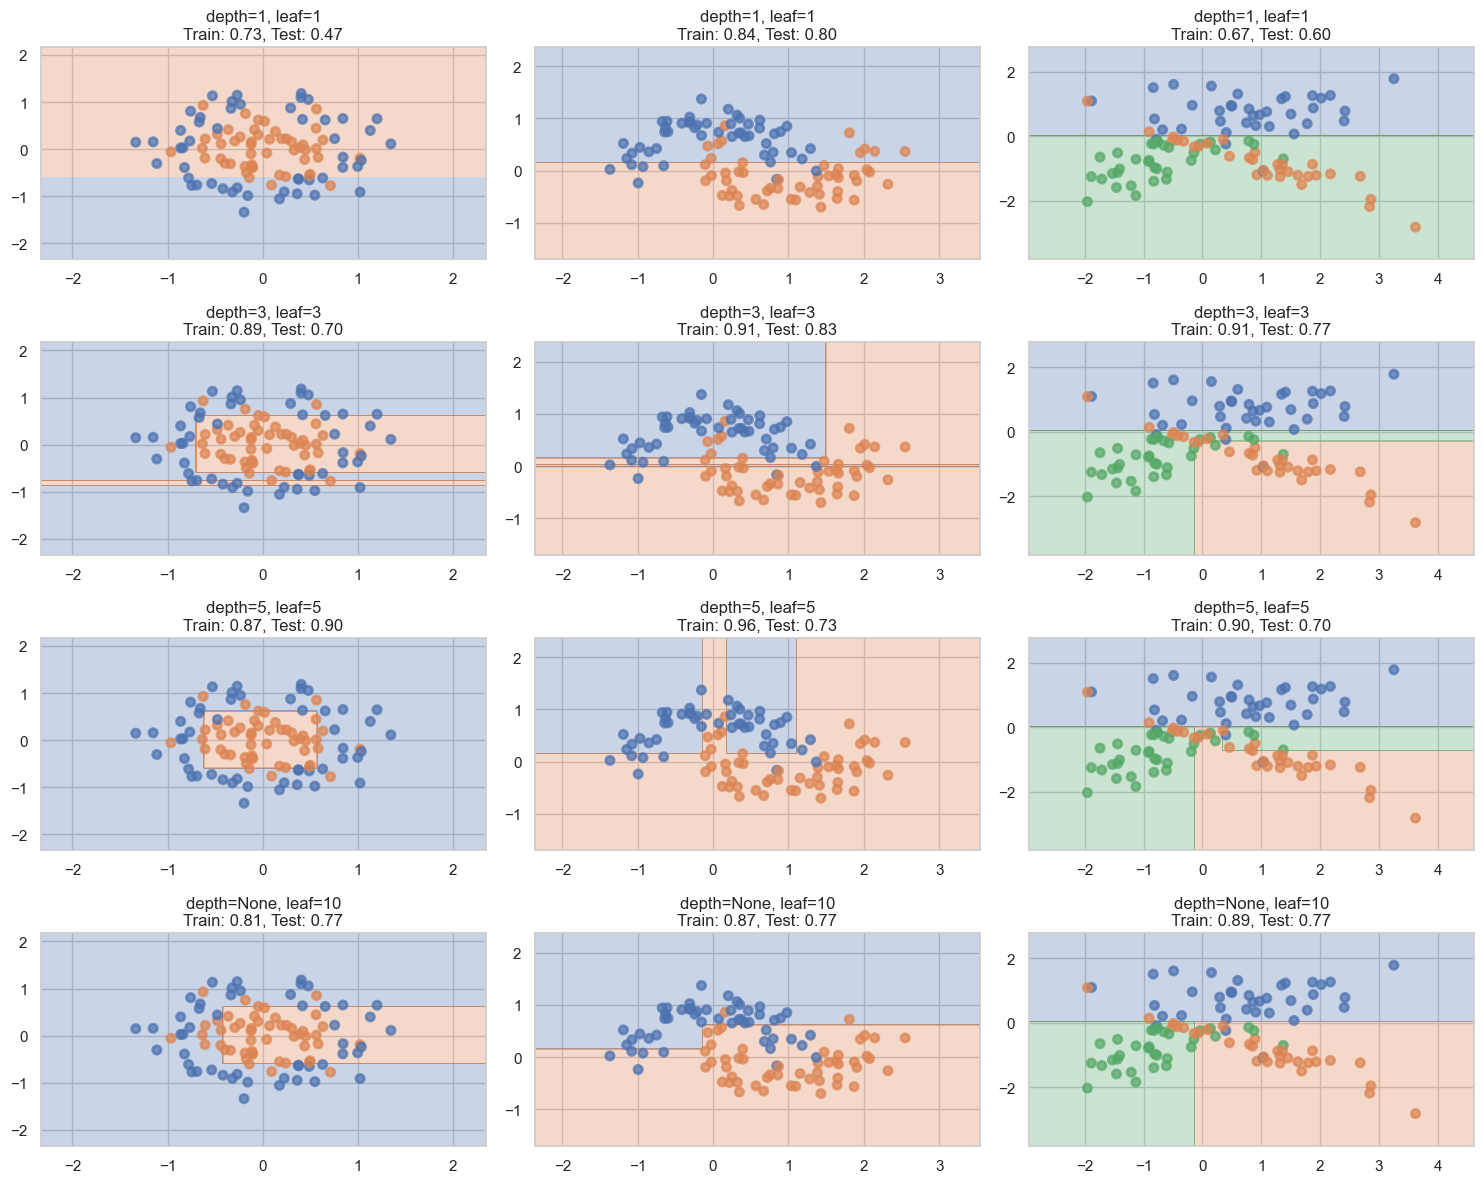

In [22]:

param_grid = [
    {"max_depth": 1, "min_leaf": 1},
    {"max_depth": 3, "min_leaf": 3},
    {"max_depth": 5, "min_leaf": 5},
    {"max_depth": None, "min_leaf": 10},
]

plt.figure(figsize=(15, 12))

for row, params in enumerate(param_grid):
    for col, (X, y) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        clf = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_leaf'],
            random_state=42
        )
        clf.fit(X_train, y_train)

        acc_train = clf.score(X_train, y_train)
        acc_test = clf.score(X_test, y_test)

        plt.subplot(len(param_grid), 3, row * 3 + col + 1)
        plot_surface(clf, X, y)
        plt.title(f"depth={params['max_depth']}, leaf={params['min_leaf']}\n"
                  f"Train: {acc_train:.2f}, Test: {acc_test:.2f}")

plt.tight_layout()
plt.show()



__Ответ:__ По графикам видно, что с увеличением глубины дерева и уменьшением минимального количества объектов в листьях разделяющая поверхность становится более сложной и изломанной. Это говорит о росте гибкости модели и о повышении риска переобучения

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

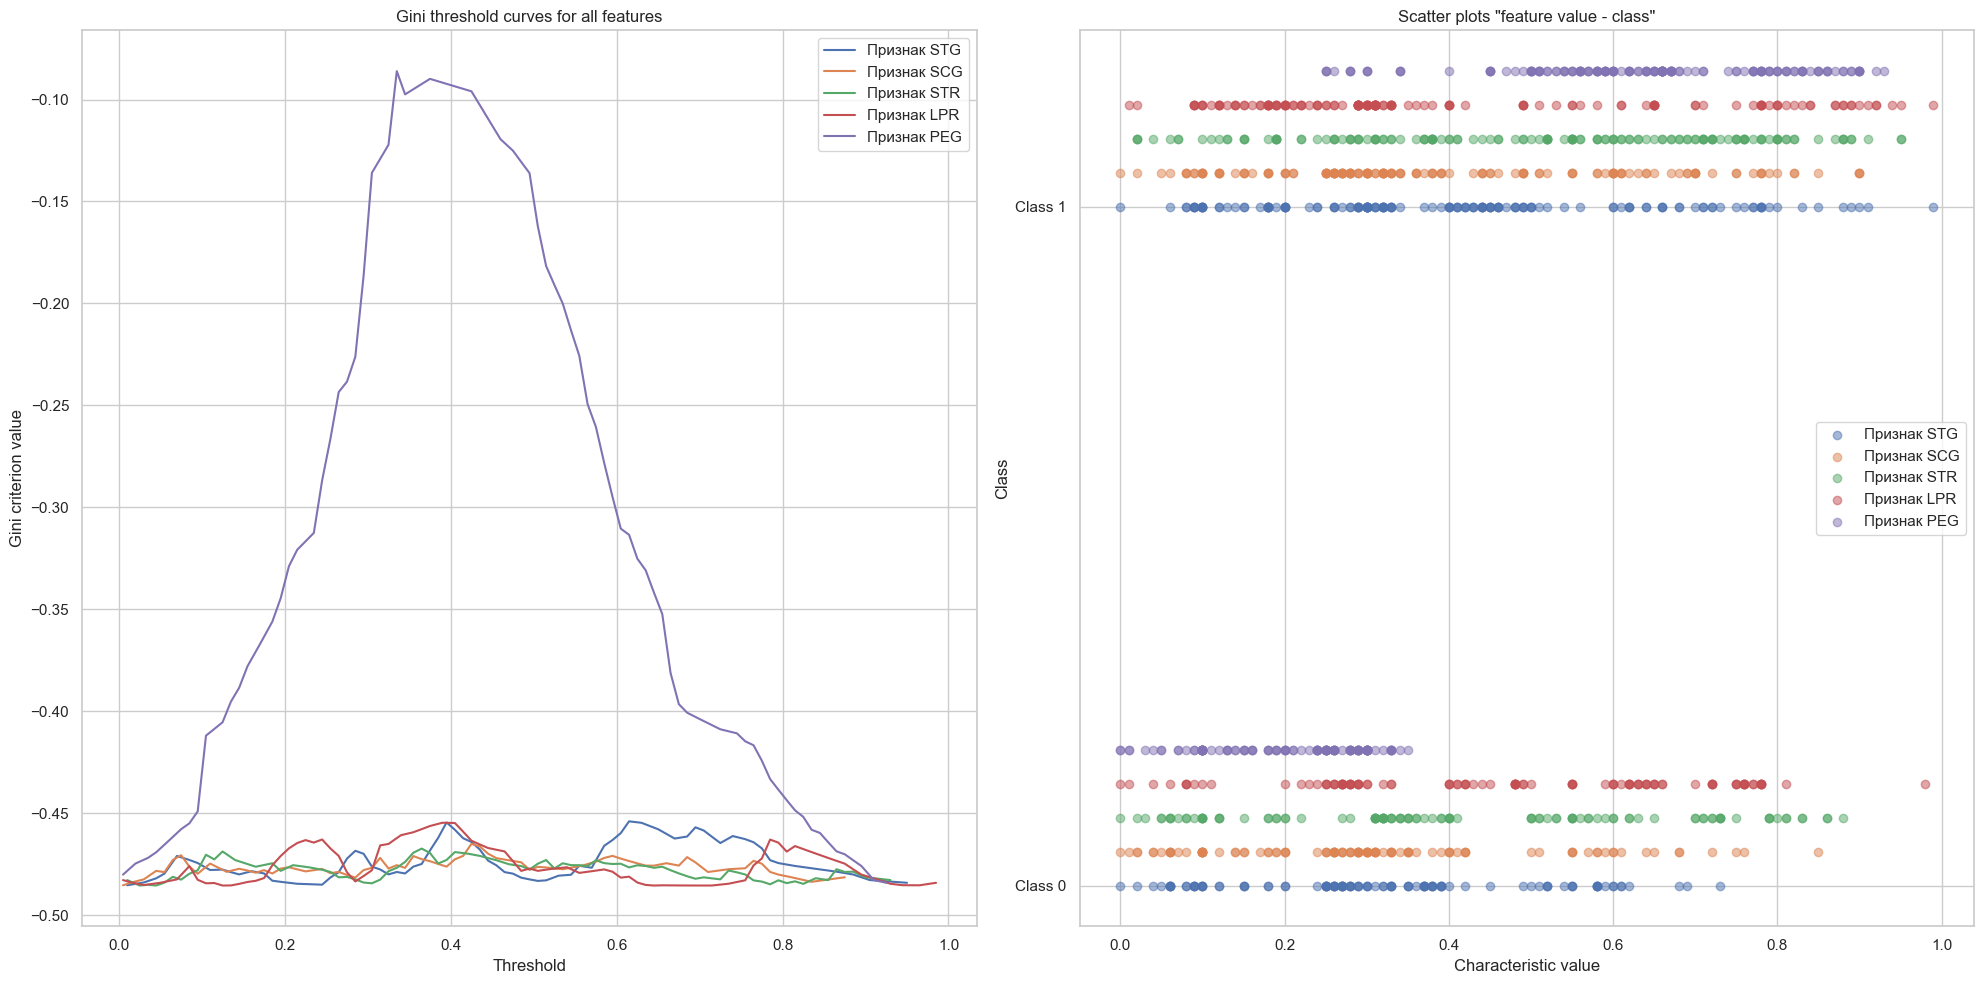

In [5]:
from hw2code import find_best_split

data = pd.read_csv('students.csv')
features = data.iloc[:, :5]
target = data.iloc[:, 5]

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
for i, col in enumerate(features.columns):
    thresholds, ginis, _, _ = find_best_split(features[col].values, target.values)
    if thresholds is not None:
        plt.plot(thresholds, ginis, label=f'Признак {col}')
plt.xlabel('Threshold')
plt.ylabel('Gini criterion value')
plt.title('Gini threshold curves for all features')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, col in enumerate(features.columns):
    plt.scatter(features[col], target + i*0.05, label=f'Признак {col}', alpha=0.5)
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Characteristic value')
plt.ylabel('Class')
plt.title('Scatter plots "feature value - class"')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** По графикам значений критерия Джини можно определить, какой признак лучше всего подходит для разделения выборки. Если кривая Джини для признака резко поднимается и имеет чётко выраженные пики, особенно вблизи значения 0.5, это означает, что при определённом пороге данный признак хорошо разделяет объекты разных классов. Такие признаки считаются информативными. Это подтверждается и на scatter-графиках — классы отчётливо разделяются вдоль оси такого признака. Визуально кривая выглядит как один или несколько резких пиков. Напротив, если кривая Джини почти плоская и её значения близки к нулю, это указывает на то, что признак не способен эффективно разделить классы: объекты разных классов сильно перемешаны, и вне зависимости от выбранного порога качество разбиения остаётся низким.


__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from hw2code import DecisionTree

data = pd.read_csv('agaricus-lepiota.data', header=None)

label_encoders = []
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders.append(le)

y = data.loc[:, 0].values
X = data.loc[:, 1:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]

tree = DecisionTree(feature_types=feature_types, max_depth=None)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")

def compute_tree_depth(node):
    if node["type"] == "terminal":
        return 1
    else:
        left_depth = compute_tree_depth(node["left_child"])
        right_depth = compute_tree_depth(node["right_child"])
        return 1 + max(left_depth, right_depth)

depth = compute_tree_depth(tree._tree)
print(f"Depth: {depth}")

Accuracy: 1.000
Depth: 9


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

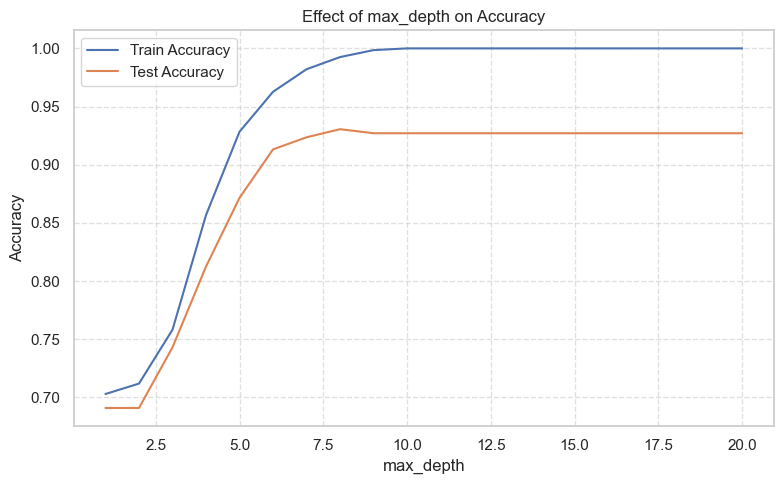

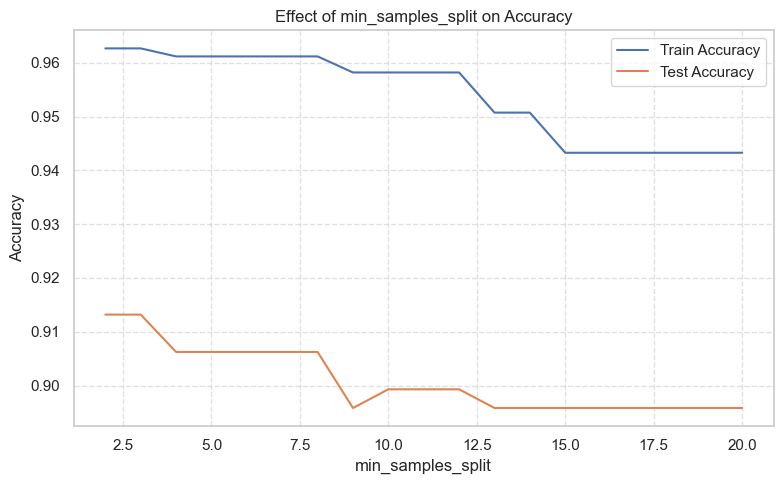

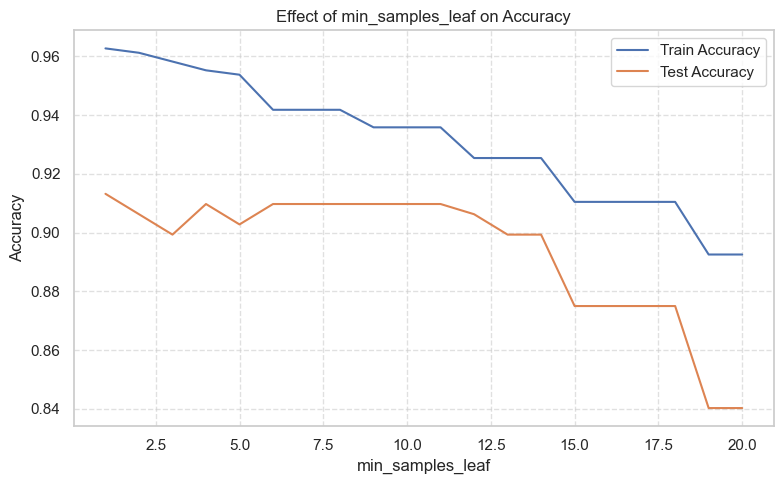

In [17]:
df = pd.read_csv('tic-tac-toe-endgame.csv')

X = df.drop(columns='V10')
X_encoded = np.zeros_like(X, dtype=int)

for i, col in enumerate(X.columns):
    le = LabelEncoder()
    X_encoded[:, i] = le.fit_transform(X[col])

y = (df['V10'] == 'positive').astype(int).values
feature_types = ['categorical'] * X_encoded.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)
train_scores = []
test_scores = []

for val in range(1, 21):
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=val,
        min_samples_split=2,
        min_samples_leaf=1
    )
    tree.fit(X_train, y_train)
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_scores, label='Train Accuracy')
plt.plot(range(1, 21), test_scores, label='Test Accuracy')
plt.title('Effect of max_depth on Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

train_scores = []
test_scores = []

for val in range(2, 21):
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=6,
        min_samples_split=val,
        min_samples_leaf=1
    )
    tree.fit(X_train, y_train)
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), train_scores, label='Train Accuracy')
plt.plot(range(2, 21), test_scores, label='Test Accuracy')
plt.title('Effect of min_samples_split on Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
train_scores = []
test_scores = []

for val in range(1, 21):
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=val
    )
    tree.fit(X_train, y_train)
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_scores, label='Train Accuracy')
plt.plot(range(1, 21), test_scores, label='Test Accuracy')
plt.title('Effect of min_samples_leaf on Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания: